In [26]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']  # For Mac
plt.rcParams['axes.unicode_minus'] = False  # This is to display minus signs correctly



In [27]:
df_demand = pd.read_csv('./data/demand_train.csv',  encoding="gbk")
df_demand['过账日期'] = pd.to_datetime(df_demand['过账日期'])

df_demand.head(10)

,过账日期,需求量,工厂编码,物料编码,物料品牌,物料类型,物料品类
0,2018-01-06,0.33,2004,1000,5000,3002,4014
1,2018-01-08,0.09,2010,1000,5000,3002,4014
2,2018-01-09,0.09,2008,1000,5000,3002,4014
3,2018-01-10,0.10,2010,1000,5000,3002,4014
4,2018-01-11,0.17,2004,1000,5000,3002,4014
5,2018-01-13,0.06,2008,1000,5000,3002,4014
6,2018-01-15,0.45,2004,1000,5000,3002,4014
7,2018-01-18,0.03,2010,1000,5000,3002,4014
8,2018-01-19,0.06,2008,1000,5000,3002,4014
9,2018-01-20,0.84,2004,1000,5000,3002,4014


In [28]:
df_demand['年月'] = df_demand['过账日期'].dt.to_period('M').astype(str)
df_demand['月'] = df_demand['年月'].str[-2:]
df_demand['季度'] = df_demand['过账日期'].dt.quarter
df_demand.head()

,过账日期,需求量,工厂编码,物料编码,物料品牌,物料类型,物料品类,年月,月,季度
0,2018-01-06,0.33,2004,1000,5000,3002,4014,2018-01,01,1
1,2018-01-08,0.09,2010,1000,5000,3002,4014,2018-01,01,1
2,2018-01-09,0.09,2008,1000,5000,3002,4014,2018-01,01,1
3,2018-01-10,0.10,2010,1000,5000,3002,4014,2018-01,01,1
4,2018-01-11,0.17,2004,1000,5000,3002,4014,2018-01,01,1


In [29]:
df_demand.drop(['过账日期', '物料品牌', '物料类型', '物料品类'], axis=1, inplace=True)
df_demand.head()

,需求量,工厂编码,物料编码,年月,月,季度
0,0.33,2004,1000,2018-01,01,1
1,0.09,2010,1000,2018-01,01,1
2,0.09,2008,1000,2018-01,01,1
3,0.10,2010,1000,2018-01,01,1
4,0.17,2004,1000,2018-01,01,1


In [30]:
# 经分析 需求量与库存量、物料编码、工厂编码有很大可能存在关联性，考虑到最终预测是通过工厂编码 + 物料编码 进行预测的，故这里将数据进行预处理

df_demand['工厂编码_物料编码'] = df_demand['工厂编码'].astype(str) + '_' + df_demand['物料编码'].astype(str)
df_demand['年'] = df_demand['年月'].str[:4]
df_final = df_demand.groupby(['工厂编码_物料编码', '年月', '年', '月', '季度']).agg({'需求量': 'sum' }).reset_index()
df_final['年'] = df_final['年'].astype(int)
df_final['月'] = df_final['月'].astype(int)
df_final['季度'] = df_final['季度'].astype(int)
df_final.head()

,工厂编码_物料编码,年月,年,月,季度,需求量
0,2000_1001,2018-01,2018,1,1,12.53
1,2000_1001,2018-02,2018,2,1,16.08
2,2000_1001,2018-03,2018,3,1,4.71
3,2000_1001,2018-04,2018,4,2,17.69
4,2000_1001,2018-05,2018,5,2,7.97


In [31]:
# 滞后特征（过去3个月需求量）
for lag in [1, 2, 3, 4]:
    df_final[f'lag_{lag}'] = df_final.groupby(['工厂编码_物料编码'])['需求量'].shift(lag)
df_final.head()

,工厂编码_物料编码,年月,年,月,季度,需求量,lag_1,lag_2,lag_3,lag_4
0,2000_1001,2018-01,2018,1,1,12.53,NaN,NaN,NaN,NaN
1,2000_1001,2018-02,2018,2,1,16.08,12.53,NaN,NaN,NaN
2,2000_1001,2018-03,2018,3,1,4.71,16.08,12.53,NaN,NaN
3,2000_1001,2018-04,2018,4,2,17.69,4.71,16.08,12.53,NaN
4,2000_1001,2018-05,2018,5,2,7.97,17.69,4.71,16.08,12.53


In [32]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df_final['工厂编码_物料编码'] = le.fit_transform(df_final['工厂编码_物料编码'])
df_final.head()

,工厂编码_物料编码,年月,年,月,季度,需求量,lag_1,lag_2,lag_3,lag_4
0,0,2018-01,2018,1,1,12.53,NaN,NaN,NaN,NaN
1,0,2018-02,2018,2,1,16.08,12.53,NaN,NaN,NaN
2,0,2018-03,2018,3,1,4.71,16.08,12.53,NaN,NaN
3,0,2018-04,2018,4,2,17.69,4.71,16.08,12.53,NaN
4,0,2018-05,2018,5,2,7.97,17.69,4.71,16.08,12.53


In [33]:


# 划分训练集和测试集
df_train = df_final[df_final['年月'] < '2020-09']
df_test = df_final[df_final['年月'] >= '2020-09']
df_test.head()

,工厂编码_物料编码,年月,年,月,季度,需求量,lag_1,lag_2,lag_3,lag_4
30,0,2020-09,2020,9,3,1.80,6.00,13.20,10.28,21.76
31,0,2020-10,2020,10,4,4.80,1.80,6.00,13.20,10.28
32,0,2020-11,2020,11,4,8.40,4.80,1.80,6.00,13.20
65,1,2020-09,2020,9,3,119.76,60.96,103.72,120.84,146.80
66,1,2020-10,2020,10,4,131.72,119.76,60.96,103.72,120.84


In [34]:
#  训练模型
features = ['年', '月', '季度', 'lag_1', 'lag_2', 'lag_3', '工厂编码_物料编码']
target = '需求量'
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [35]:
# from pmdarima import auto_arima
from xgboost import XGBRegressor

X_train = df_train[features]
y_train = df_train[target]
X_test = df_test[features]
y_test = df_test[target]
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
eval_set = [(X_train, y_train)]
xgb_model.fit(X_train, y_train, eval_set=eval_set, verbose=False)
xgb_train_error = xgb_model.evals_result()['validation_0']['rmse']

# 预测并计算 MSE
xgb_pred = xgb_model.predict(X_test)
xgb_mse = mean_squared_error(y_test, xgb_pred)
mae = mean_absolute_error(df_test[target], xgb_pred)

# 打印结果
print(f"MSE: {xgb_mse:.4f}")
print(f"MAE: {mae:.4f}")


MSE: 23732.8532
MAE: 61.3476


In [36]:
df_predict_xgb = df_test.copy()

df_predict_xgb['预测值'] = xgb_pred  # 添加预测值列

# 2. 计算绝对差异和相对差异
df_predict_xgb['绝对差异'] = df_predict_xgb['预测值'] - df_predict_xgb['需求量']
df_predict_xgb['相对差异(%)'] = (df_predict_xgb['绝对差异'] / df_predict_xgb['需求量']).abs() * 100

# 3. 按绝对差异排序（可选）
df_compare_xgb = df_predict_xgb.sort_values(by='相对差异(%)', key=abs, ascending=False)

# 4. 显示关键列（按需调整显示的列）
columns_to_show = ['工厂编码_物料编码', '年月', '需求量', '预测值', '绝对差异', '相对差异(%)']
df_compare_xgb = df_compare_xgb[columns_to_show]

# 5. 格式化输出（保留两位小数）
pd.options.display.float_format = '{:.2f}'.format
print("预测值与真实值对比表：")
df_compare_xgb.head(10)  # 显示差异最大的前10条样本

预测值与真实值对比表：


,工厂编码_物料编码,年月,需求量,预测值,绝对差异,相对差异(%)
10114,648,2020-10,0.04,71.92,71.88,179706.73
7264,481,2020-09,0.08,6.10,6.02,7522.08
7195,464,2020-09,0.40,21.92,21.52,5380.02
4802,290,2020-11,0.28,15.21,14.93,5332.80
3816,221,2020-09,1.00,47.62,46.62,4662.22
5075,319,2020-11,1.40,46.47,45.07,3219.15
3501,197,2020-09,2.00,44.01,42.01,2100.27
9475,608,2020-11,0.24,5.16,4.92,2048.13
4572,270,2020-09,0.35,6.87,6.52,1861.93
4352,256,2020-11,1.00,18.99,17.99,1798.98


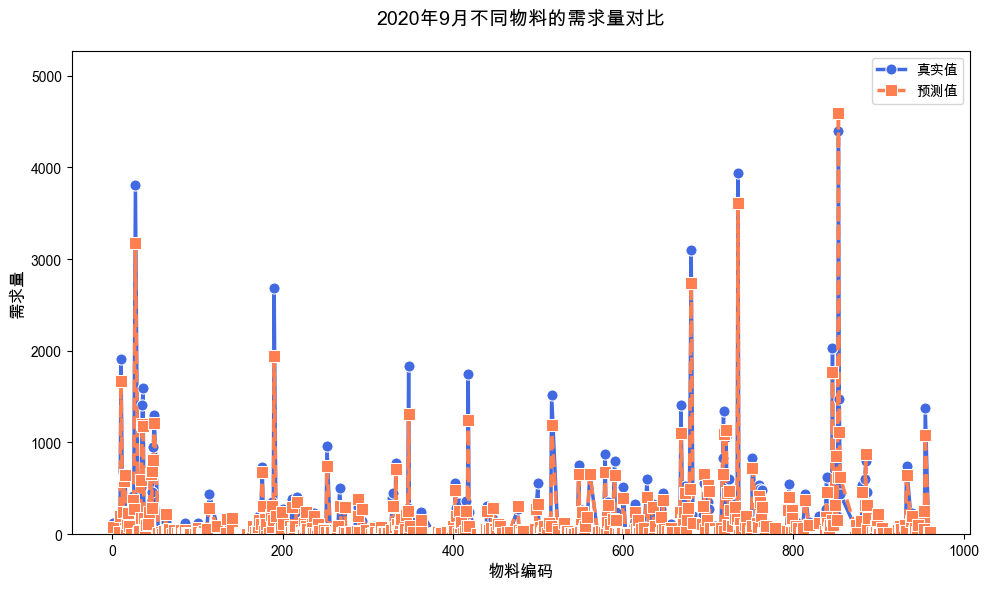

In [37]:
df_test_xgb_9 = df_predict_xgb[df_test['年月'] == '2020-09']
plt.figure(figsize=(10, 6))

# 绘制折线图（带标记点）
lineplot = sns.lineplot(
    data=df_test_xgb_9,
    x='工厂编码_物料编码',
    y='需求量',
    marker='o',
    markersize=8,
    linewidth=2.5,
    color='royalblue',
    label='真实值'
)
sns.lineplot(
    data=df_test_xgb_9,
    x='工厂编码_物料编码',
    y='预测值',
    marker='s',
    markersize=8,
    linewidth=2.5,
    color='coral',
    linestyle='--',
    label='预测值'
)

plt.title('2020年9月不同物料的需求量对比', fontsize=14, pad=20)
plt.xlabel('物料编码', fontsize=12)
plt.ylabel('需求量', fontsize=12)

# 调整Y轴范围（考虑数值差异大的情况）
plt.ylim(0, df_test_xgb_9['需求量'].max() * 1.2)

# 显示图表
plt.tight_layout()
plt.show()